In [82]:
in_path =r'../../data/clean/' # use your path

import pandas as pd
pd.set_option('display.max_columns', 500)
import glob
import re
from nltk import stem
porter = stem.porter.PorterStemmer()
from gensim import corpora, models, similarities
import matplotlib.pyplot as plt
%matplotlib inline

 

def extract_docs(df):
    docs_csv=out_path+"docs.csv"
    df.AB.to_csv(docs_csv, index=False)
    print len(df)
    with open(docs_csv) as f:
        docs = f.readlines()    
    return docs

def pre(docs):
    docs_prepared=out_path+'docs_prepared.csv'
    stop= open ('stopList.txt').read()
    stop_list = set(stop.replace("\n", " ").split())
    docs_cleaned = [[re.sub('[.!,;?()\W\d]+', '', word) for word in doc.lower().split()] for doc in docs]
    docs_stemed = [[porter.stem(word) for word in document if word not in stop_list] for document in docs_cleaned]
    with open(docs_prepared, 'w') as f:
        for doc in docs_stemed:f.write("%s\n" % ' '.join(doc))
    return docs_stemed

def sims():
    index = similarities.MatrixSimilarity(corpus_lsi) 
    lines = docs
    sims = open('lsi.csv', 'w')
    #countdegree= open('09 LSI - degreecount.csv', 'w')
    sims.write('source,target,weight,type\n')
    for i in range(len(docs)):
        doc=lines[i]    
        vec_bow = dictionary.doc2bow(doc)
        vec_tran = lsi[tfidf[vec_bow]]
        #vec_tran = lda[tfidf[vec_bow]]
        simsinx = index[vec_tran]
        #count=0;
        #for j in range(0,len(simsinx)):
            #if simsinx[j]>.5: 
                #count=count+1
        #countdegree.write(str(i+1)+','+str(count-1));countdegree.write('\n')
        for j in range(i+1,len(simsinx)):
            if simsinx[j]>0:                                        
                sims.write(str(i)+','+str(j)+','+str(simsinx[j])+',undirected\n')
    sims.close()

In [86]:
df=pd.read_csv(in_path+"articles.csv")

In [87]:
docs=extract_docs(df)

1207


In [50]:
docs=pre(docs)

In [51]:
## documents_clean = [[word for word in document.split() ] for document in docs]
dictionary = corpora.Dictionary(docs)
dictionary.filter_extremes(no_below=5)
dictionary.compactify() 
print dictionary

class MyCorpus(object):
    def __iter__(self):
        for doc in docs:
            yield dictionary.doc2bow(doc)
corpus= MyCorpus() 
corpora.MmCorpus.serialize('deerwester.mm', corpus)
corpus = corpora.MmCorpus('deerwester.mm')
print corpus

Dictionary(2014 unique tokens: [u'', u'assimil', u'payoff', u'accur', u'deviat']...)
MmCorpus(1207 documents, 2014 features, 71503 non-zero entries)


In [52]:
tfidf = models.tfidfmodel.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=100) 
corpus_lsi=lsi[corpus_tfidf]


In [53]:
sims()

In [69]:
df=pd.read_csv('lsi.csv')
df=df[df.weight>.4]
df.shape

(13676, 4)

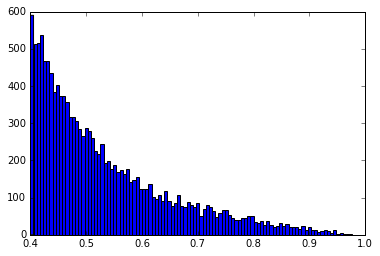

In [70]:
import numpy as np
l=df.weight
hist=plt.hist(l,101)

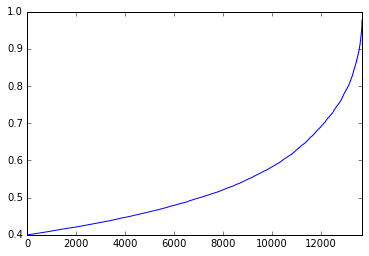

In [71]:
l=l.sort_values()
l=l.reset_index(drop=True)
l.plot(drawstyle='steps')

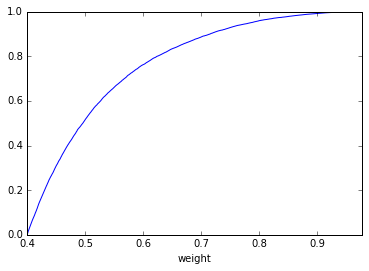

In [72]:
cum_dist = np.linspace(0.,1.,len(l))
cdf = pd.Series(cum_dist, index=l)
cdf.plot()

In [73]:
dic=cdf.to_dict()
df['p']=df.weight.apply(lambda x :1- dic[x])

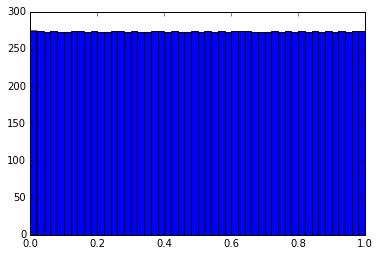

In [74]:
p=df.p
binwidth=.01
hist=plt.hist(p,50 )

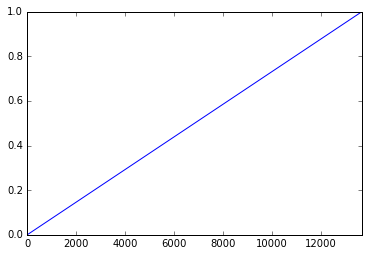

In [75]:
p=df.p
p=p.sort_values()
p=p.reset_index(drop=True)
p.plot(drawstyle='steps')

In [76]:
df.shape

(13676, 5)

In [81]:
df[['source','target','p']].to_csv('p_lsi.csv',index=False)